# Evaluating Machine Learning Models Against the Black-Scholes Formula for Option Pricing.

### Introduction

The aim of this project is to build and train two machine learning models (Neural Network and XGBoost) and compare them to the traditional Black-Scholes formula for option pricing. This model is built on assumptions about the market data. While the Black-Scholes model is able to produce powerful results, machine learning models will be implemented to test whether these assumptions lead to less accurate predictions, compared to results based entirely on processed data. Using the variables in the Black-Scholes equation as input features, models will be trained for 5 different companies and compared, using common statistical metrics. Finally, the conclusion will compare the ML approaches to the Black-Scholes equation, and it will be clear which method is better for option pricing.



Begin by importing the key libraries used throughout this project. Pandas are a key library used for working with structured data, where key variables are stored in DataFrames, making them easy to extract and use for analysis.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

%matplotlib inline 

## The Black-Scholes Formula

The Black-Scholes model, founded by Fischer Black and Myron Scholes, provided the first solution for pricing European options. It forms the foundation and core reference point for market practice as well as academic research, and remains one of the most famous and influential equations in finance today. The model assumes frictionless markets, constant volatility and continuous trading, simplifying the complexity of real market data whilst still remaining accurate. This formula will serve as the benchmark used to compare against other machine learning methods.

There are two types of options, call and put options. Call options give the owner the right but not the obligation to buy an asset at a pre-specified price (the strike price). Similarly, put options give the owner the right but not the obligation to sell an asset at the strike price. The Black-Scholes formula varies slightly depending on which option type is selected.

In [23]:
from scipy.stats import norm #Retrieve normal distribution used in BS formula

def black_scholes(S, K, T, r, sigma, option_type="call"):

    #Calculate intermediate values d1 and d2
    d1 = (np.log(S/K) + (r + (sigma ** 2) / 2) * T) / (sigma * (T ** (1/2)))
    d2 = (np.log(S/K) + (r - (sigma ** 2) / 2) * T) / (sigma * (T ** (1/2)))

    #Calculate option price depending wether call or put option
    if option_type == "call":
        #norm.cdf gives the cumulative distribution function of the normal distribution (mean=0, s.d = 1)
        price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be either 'call' or 'put'")
    
    return price


### Create Statistical Analysis Function

Before implementing the models, a function to compare how well each model performs is created. This function will calculate several common statistical metrics to measure the difference between predicted and actual prices. This will be run individually to each model, and used for later comparison between them.

In [24]:
from sklearn import metrics

def model_stats(true_vals, predicted_vals):

    #Different statistical metrics to evaluate how well a model fits
    mse = metrics.mean_squared_error(true_vals, predicted_vals)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(true_vals, predicted_vals)
    r2_score = metrics.r2_score(true_vals, predicted_vals)

    #Store the stats in a dictionary to return for each model
    stats = {
        "RMSE": rmse, #Root mean squared error
        "MAE": mae, #Mean average error
        "R2": r2_score #R squared score
    }

    return stats


### Comparing Black-Scholes Against the Market

The first step of this project is to test the Black-Scholes model using real world data, made possible through the use of the yfinance library, which contains live option chain data for public use. It compares the Black-Scholes prices with the actual market prices for a certain stock, across a range of expiry dates. 

For each expiry, the function extracts the stock's latest price, strike price and implied volatility, then computes the corresponding Black-Scholes values.

A small random sample of expiries are taken and plotted to visually show the comparison between predicted and actual prices. Several error metrics are used to quantify how closely the model aligns with the data: Root Mean Squared Error (RMSE), Mean Average Error (MAE), and the R-squared value (R<sup>2</sup>). 

In [25]:
import yfinance as yf
import datetime

def bs_vs_market(company, r, n_expiries, opt_type="call"):
    
    #Get ticker data from yfinance
    ticker = yf.Ticker(company)
    expiries = ticker.options #List of the expiry dates
    
    #Get the stock price (S), looking at the last available closing price
    S = ticker.history(period="1d")["Close"][-1]

    today = datetime.datetime.today() #Obtain current date
    min_days = 7 #Sometimes options expiring soon negatively affect results
    results = []

    #Loop over all expiry dates 
    for expiry in expiries:
        #Calculate T for BS model (in years)
        expiry_date = datetime.datetime.strptime(expiry, "%Y-%m-%d")
        days_left = (expiry_date - today).days
        T = days_left / 365

        #Ignore expired options and options expiring too soon
        if T <= 0 or days_left < min_days:
            continue

        #Extract all options for the specific expiry
        opt_chain = ticker.option_chain(expiry)
        
        #Select calls or puts based on option_type argument
        if opt_type == "call":
            options = opt_chain.calls
        elif opt_type == "put":
            options = opt_chain.puts
        else:
            raise ValueError("opt_type must be 'call' or 'put'")

        #Extract variables from the options table
        for _, row in options.iterrows():
            K = row["strike"] #Strike price
            market_price = row["lastPrice"] #Current market price
            sigma = row["impliedVolatility"] #Implied Volatility

            # Calculate black-Scholes prediction
            if T > 0 and sigma > 0:
                bs_price = black_scholes(S=S, K=K, T=T, r=r, sigma=sigma, option_type=opt_type)
                results.append([expiry, K, market_price, bs_price, sigma])

    #Convert to DataFrame
    bs_comparison = pd.DataFrame(results, columns=["Expiry", "Strike", "MarketPrice", "BSPrice", "ImpliedVolatility"])

    print(f"\nComparison of Black-Scholes Prediction vs Market Price for {company} ({opt_type} options):\n")
    print(bs_comparison.head(5)) #Print first 5 comparisons

    #Pick random expiries to compare market prices vs Black-Scholes predictions
    unique_expiries = list(bs_comparison["Expiry"].unique())
    sample_expiries = random.sample(unique_expiries, n_expiries)

    #Create individual plots comparing the real market values to the Black-Scholes predictions for each chosen expiry
    plt.figure(figsize=(18, 4.5))
    for i, expiry in enumerate(sample_expiries):
        expiry_options = bs_comparison[bs_comparison["Expiry"] == expiry] #Extract data for that expiry from the DataFrame

        plt.subplot(1, 3, i+1)
        plt.scatter(expiry_options["Strike"], expiry_options["MarketPrice"], label="Market Price", color="green")
        plt.scatter(expiry_options["Strike"], expiry_options["BSPrice"], label="Black-Scholes Price", color="black")
        plt.xlabel("Strike ($)")
        plt.ylabel("Option Price ($)")
        plt.title(f"{company} {opt_type.title()} Options (Expiry {expiry})")
        plt.legend()

    plt.tight_layout()
    plt.show()

    #Error analysis
    real_vals = bs_comparison["MarketPrice"]
    pred_vals = bs_comparison["BSPrice"]

    #Call function to obtain metrics for how well Black-Scholes fits
    bs_stats = model_stats(real_vals, pred_vals)

    #Extract and print error metrics from the dictionary
    print("Statistical Analysis:\n")
    for i, j in bs_stats.items():
        print(f"{i}: {j:.8f}")
    print("\n/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////\n")
    
    return bs_comparison, bs_stats


Now run the bs_vs_market function on the list of 5 companies to see if the market prices are similar to the prices predicted from the Black-Scholes model. The companies used to test the models are: Apple, Microsoft, Amazon, Google and Meta, 5 of the largest companies with plenty of option data.

/tmp/ipykernel_2320/3485843728.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = ticker.history(period="1d")["Close"][-1]



Comparison of Black-Scholes Prediction vs Market Price for AAPL (call options):

       Expiry  Strike  MarketPrice     BSPrice  ImpliedVolatility
0  2025-11-07   110.0       148.43  159.344546           2.027349
1  2025-11-07   120.0       136.28  149.317654           0.000010
2  2025-11-07   140.0       116.30  129.405422           1.583986
3  2025-11-07   145.0       117.07  124.411927           1.505862
4  2025-11-07   150.0       113.49  119.418209           1.429690


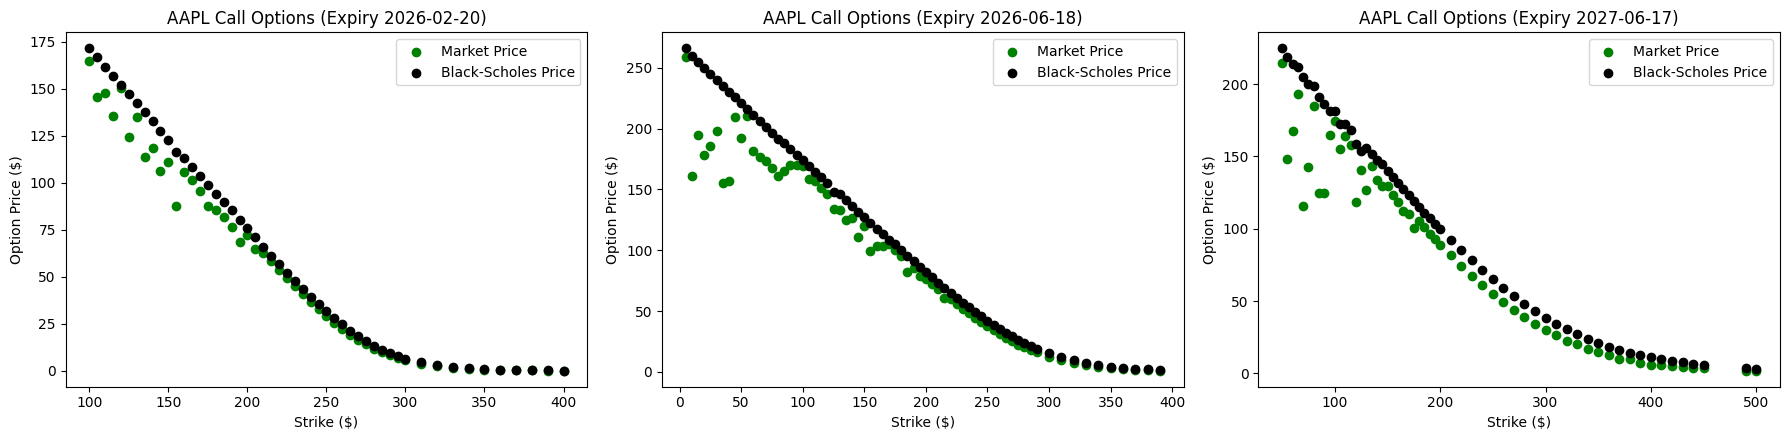

Statistical Analysis:

RMSE: 15.37202904
MAE: 8.98316588
R2: 0.94712035

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////



/tmp/ipykernel_2320/3485843728.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = ticker.history(period="1d")["Close"][-1]



Comparison of Black-Scholes Prediction vs Market Price for MSFT (call options):

       Expiry  Strike  MarketPrice     BSPrice  ImpliedVolatility
0  2025-11-07   270.0       248.70  273.402094           1.807618
1  2025-11-07   280.0       234.52  263.467581           1.762208
2  2025-11-07   290.0       225.27  253.441908           1.648439
3  2025-11-07   300.0       216.86  243.481442           1.585940
4  2025-11-07   310.0       208.88  233.563807           1.548342


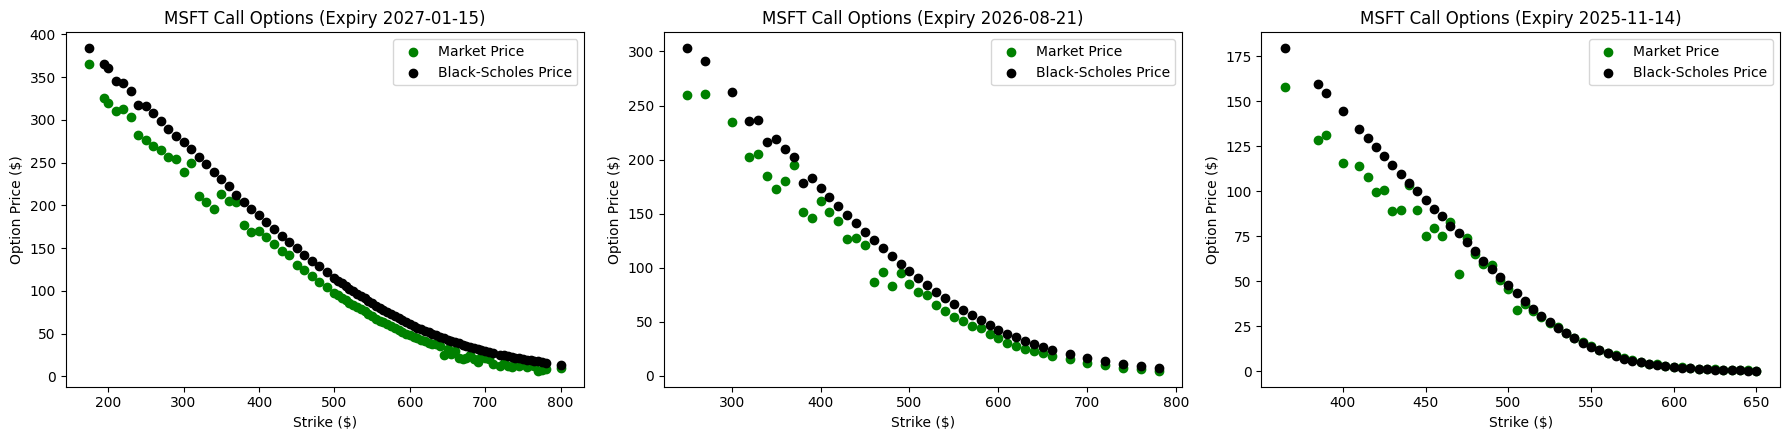

Statistical Analysis:

RMSE: 26.04123722
MAE: 17.02528464
R2: 0.92554540

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////



/tmp/ipykernel_2320/3485843728.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = ticker.history(period="1d")["Close"][-1]



Comparison of Black-Scholes Prediction vs Market Price for AMZN (call options):

       Expiry  Strike  MarketPrice     BSPrice  ImpliedVolatility
0  2025-11-07   120.0        93.35  109.588963           1.398441
1  2025-11-07   125.0        96.60  104.628643           1.466800
2  2025-11-07   130.0        90.45   99.591918           1.148442
3  2025-11-07   140.0        89.25   89.648012           1.214848
4  2025-11-07   145.0        82.71   84.654644           1.136723


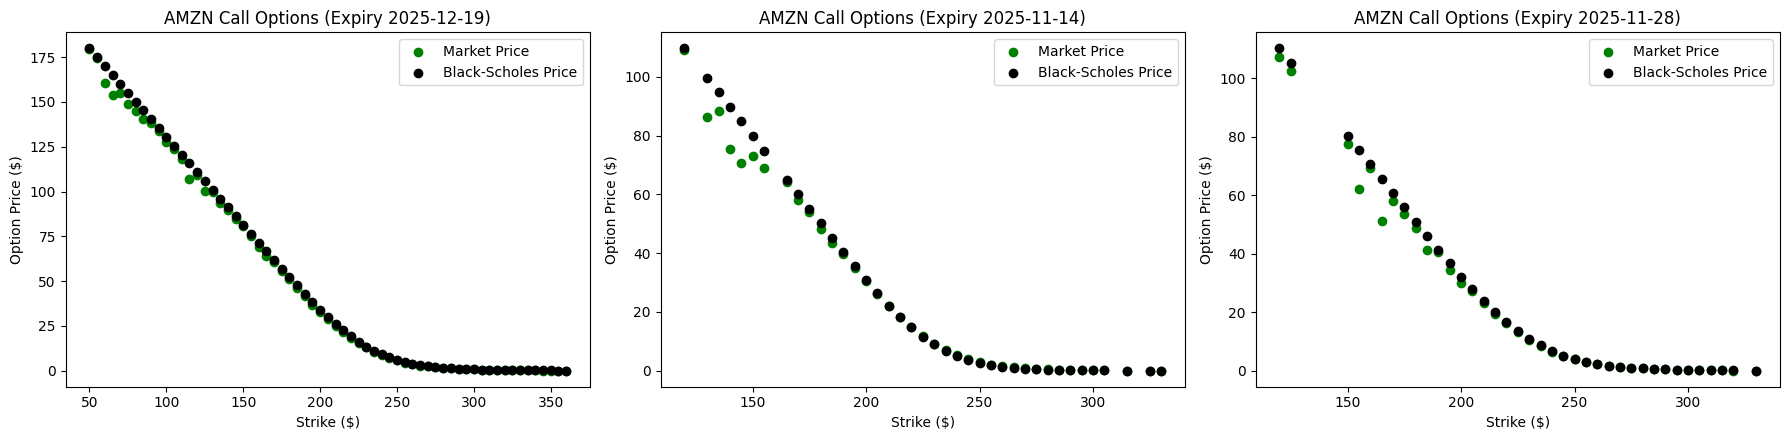

Statistical Analysis:

RMSE: 5.73044262
MAE: 4.15760176
R2: 0.98215095

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////



/tmp/ipykernel_2320/3485843728.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = ticker.history(period="1d")["Close"][-1]



Comparison of Black-Scholes Prediction vs Market Price for GOOGL (call options):

       Expiry  Strike  MarketPrice     BSPrice  ImpliedVolatility
0  2025-11-07   100.0       146.50  168.818717           3.086916
1  2025-11-07   135.0       110.62  133.907537           2.244145
2  2025-11-07   140.0       105.54  128.884033           2.121098
3  2025-11-07   160.0       107.42  108.492049           1.458987
4  2025-11-07   165.0       103.09  103.499581           1.381839


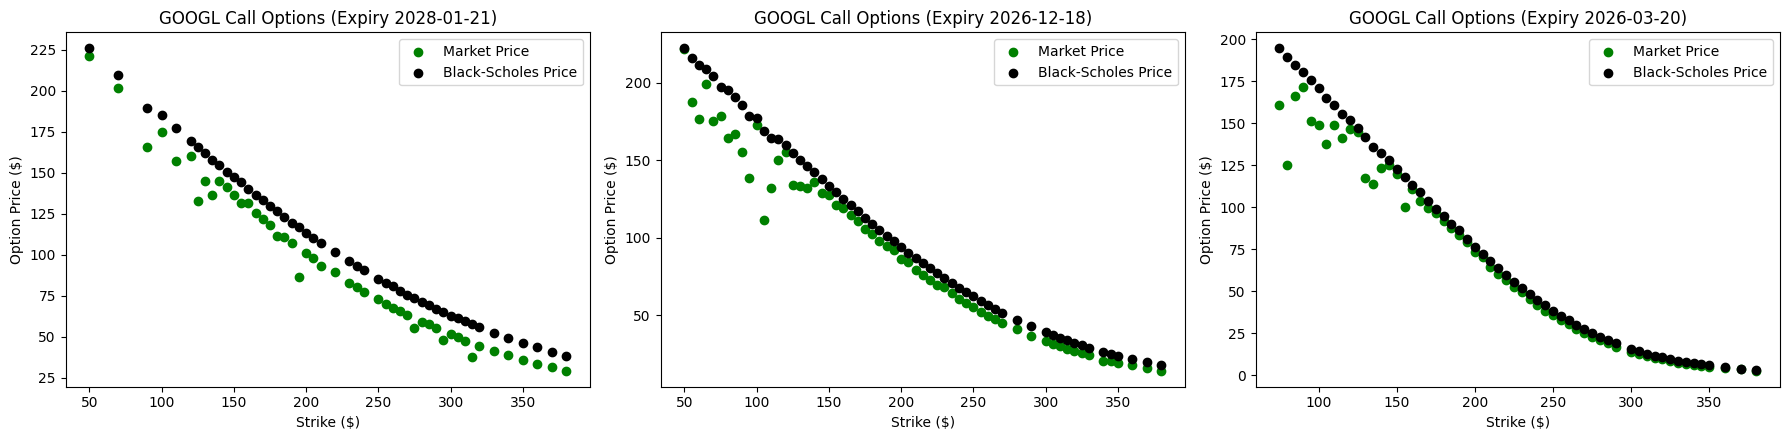

Statistical Analysis:

RMSE: 16.41413457
MAE: 8.98837206
R2: 0.91184600

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////



/tmp/ipykernel_2320/3485843728.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = ticker.history(period="1d")["Close"][-1]



Comparison of Black-Scholes Prediction vs Market Price for META (call options):

       Expiry  Strike  MarketPrice     BSPrice  ImpliedVolatility
0  2025-11-07   300.0       422.27  454.989733           1.718751
1  2025-11-07   320.0       383.93  435.302183           2.160161
2  2025-11-07   330.0       390.72  425.216857           1.999023
3  2025-11-07   340.0       375.80  415.229539           1.931641
4  2025-11-07   360.0       373.11  395.731660           2.082036


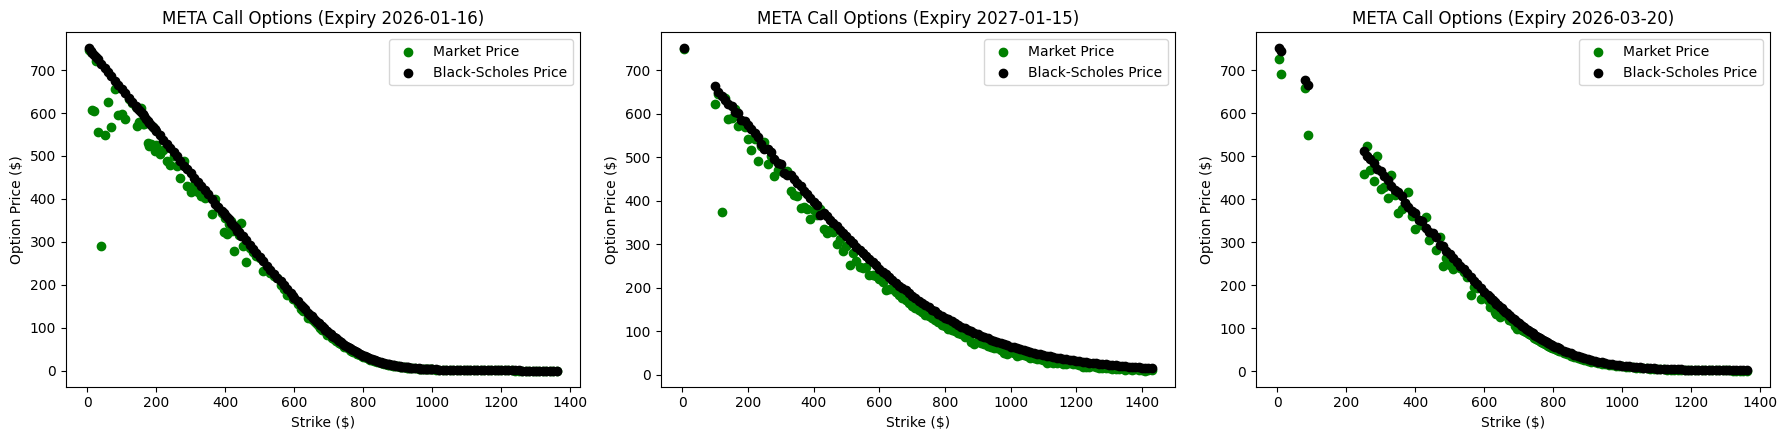

Statistical Analysis:

RMSE: 36.13862761
MAE: 19.17656237
R2: 0.96326133

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////



In [26]:
#Define the list of companies to investigate
companies = ["AAPL", "MSFT", "AMZN", "GOOGL", "META"]

#Define variables for the model
num_expiries = 3
opt_type = 'call' 
r = 0.05 #Constant approximation of the risk-free interest rate

all_results = {}
all_bs_stats = {}

#Store results of the comparison for each company in a dictionary
for company in companies:
    bs_comparison, bs_stats = bs_vs_market(company, r=r, n_expiries=num_expiries, opt_type=opt_type)
    all_results[company] = bs_comparison
    all_bs_stats[company] = bs_stats
    

# Neural Network

### Preparing the Data

To train a neural network, the first step is obtaining a clean and structured dataset that the model will be trained on. This function returns all the input features for the neural network, as well as extra data that will be used to visually display the graphs. 

The features included are the time to expiry, strike price, stock price, implied volatility, risk-free intrest rate, and the type of option (call or put). The option type has been binary encoded as 1 for call, and 0 for put. 

The data is split into training and testing sets, a common machine learning practice to measure how well the model applies to unseen data. The split used is 80% training data, and 20% test data. All features are additionally scaled to ensure consistent ranges of values for the neural network.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prep_option_data_NN(company, all_results, r=0.05, opt_type="call", test_size=0.2):

    #Get a copy of the results from the dataframe
    bs_comparison = all_results[company].copy()
    
    #Fetch the stock price again directly (so we don’t use option price by mistake)
    ticker = yf.Ticker(company)
    S = ticker.history(period="1d")["Close"][-1]
    
    today = datetime.datetime.today()
    t_vals = []
    expiry_dates = []

    #Calculate time to expiry (T) in years for each option
    for expiry in bs_comparison["Expiry"]:
        expiry_date = datetime.datetime.strptime(expiry, "%Y-%m-%d")
        days_left = (expiry_date - today).days
        t_vals.append(days_left / 365)
        expiry_dates.append(expiry_date) #Keep the unchanged expiry date for plotting later

    #Add features to the dataframe
    bs_comparison["T"] = t_vals
    bs_comparison["StockPrice"] = S
    bs_comparison["RiskFreeInterestRate"] = r
    bs_comparison["ExpiryDate"]= expiry_dates
    
    #Binarily encode the option type
    if opt_type == "call":
        bs_comparison["OptionType"] = 1
    elif opt_type == "put":
        bs_comparison["OptionType"] = 0
    else:
        raise ValueError("opt_type must be 'call' or 'put'")
    
    #Define the input features as a vector (X) and the target value (y)
    #Ensure conversion to numpy arrays to be used in the neural network
    features = ["Strike", "StockPrice", "ImpliedVolatility", "T", "RiskFreeInterestRate", "OptionType"]
    X = bs_comparison[features].to_numpy()
    y = bs_comparison["MarketPrice"].to_numpy()
    expiry_dates = bs_comparison["ExpiryDate"].to_numpy()
    
    #Split the data into training and test sets, also keeping the expiry dates for plotting
    X_train, X_test, y_train, y_test, expiry_train, expiry_test = train_test_split(X, y, expiry_dates, test_size=test_size, random_state = 1)
    
    #Scale the features to ensure consistent ranges for the neural network
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, features, scaler, expiry_train, expiry_test


Now we have the preparation function, the next step is to generate the training data for the neural network for each selected company. This loop calls the previously defined function for each company and stores the outputs into a dictionary. Storing the data in a dictionary ensures clean organisation and allows the data to easily be accessed in following sections, for training, evaluation and visualisation.

In [28]:
data_for_NN = {}

#Loop through each company to obtain training and testing data
for company in companies:
    X_train_scaled, X_test_scaled, y_train, y_test, features, scaler, expiry_train, expiry_test = prep_option_data_NN(company, all_results, r=0.05, opt_type=opt_type, test_size=0.2)

    #Store all the data in a dictionary for each company
    data_for_NN[company] = {
        "X_train_scaled": X_train_scaled,
        "X_test": X_test_scaled,
        "y_train": y_train,
        "y_test": y_test,
        "features": features,
        "scaler": scaler,
        "expiry_train": expiry_train,
        "expiry_test": expiry_test
    }


/tmp/ipykernel_2320/2083367508.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = ticker.history(period="1d")["Close"][-1]
/tmp/ipykernel_2320/2083367508.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = ticker.history(period="1d")["Close"][-1]
/tmp/ipykernel_2320/2083367508.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = ticker.history(period="1d")["Close"][-1]
/tmp/ipykernel_2320/2083367508.py:11: FutureWarni

## Building the Neural Network

The neural network is now implemented using TensorFlow. The architecture of the neural network consists of the input layer, taking the 'shape' of the amount of input features. Two hidden layers follow, with 128 and 32 neurons respectively, using the ReLU activation function. Alternative activation functions such as the sigmoid function were tested, but the ReLU function provided better performance overall. Finally there is the output layer; a single neuron that corresponds to the predicted option price. 

The model is compiled using the Adam optimizer with a learning rate of 0.001, chosen for its efficient optimisation of gradient descent, which helps the model converge smoothly. The loss function chosen is the Mean Squared Error function, which measures the average squared distance between the predicted and real prices. 

In [29]:
#Standard neural network imports for tensorflow 
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

learning_rate = 0.001 #Controls how quickly gradient descent works

#Standard structure for simple neural network 
def create_nn(feature_count):
    nn = Sequential([

        Dense(128, activation="relu", input_shape=(feature_count,)),
        Dense(32, activation="relu"),
        Dense(1)
    
    ])

    #Adam optimizer adjusts learning rate automatically
    #Mean squared error is the standard loss function used for regression networks
    nn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = tf.keras.losses.MeanSquaredError())
    
    return nn



With the model architecture defined, the next step is to build a function that fits the neural network to the training data for each company. The model is fit using batch gradient descent, which updates the model incrementally after processing small 'batches' of data instead of the whole dataset at once, for computaional efficiency. Training is repeated over a specific number of epochs (iterations), enough so that the model can minimize the loss function and get an accurate prediction.

In [30]:
def train_nn(company, data_for_NN, epochs, batch_size, learning_rate):
    
    #Extract the previouslt split data the model will be trained on
    X_train = data_for_NN[company]["X_train_scaled"]
    y_train = data_for_NN[company]["y_train"]

    #Create the neural network with the correct input vector shape
    model = create_nn(X_train.shape[1])

    #Fit the model on the training data
    #Epochs corresponds to the number of passes the model takes through the dataset
    #Batch_size is the number of data samples handled before updating gradient descent
    #Verbose set to 0 to hide model training details
    model_results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    return model, model_results


Now the neural network is ready to be trained for each company. Once the model has been trained, it is used to preict the option prices for the unseen test set, 20% of the data that was split earlier. The test set predictions are stored with the real prices in a dictionary.

In [31]:
epochs = 50
batch_size = 64

#Initialize dictionary to store models for each company
nn_models = {}

#Train a specific neural network for each company
for company in companies:
    model, _ = train_nn(company, data_for_NN, epochs, batch_size, learning_rate)
    nn_models[company] = model

predictions = {}

#Loop through each model to make predictions on the test data
for company, model in nn_models.items():

    #Obtain test features and the true option prices
    X_test = data_for_NN[company]["X_test"]
    y_test = data_for_NN[company]["y_test"]

    #Predict the option price using the model
    y_pred = model.predict(X_test)

    #Store true and predicted model values in the dictionary
    predictions[company] = {
        "y_test": y_test,
        "y_pred": y_pred
    }

#Store the stats for each company
nn_stats = {}

for company in companies:
    nn_true_vals = predictions[company]["y_test"]
    nn_pred_vals = predictions[company]["y_pred"]

    #Call the function created initially
    nn_stats[company] = model_stats(nn_true_vals, nn_pred_vals)



/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### Plotting the Neural Network 

To visualise and evaluate the performance of the neural network, this function plots the predicted prices against the real prices for a random selection of unique expiries. Both training and testing data are shown on the plots to demonstrate how well the model was trained and how the unseen test data was predicted alongside the seen training data. 

The plotting data is extracted again, and the input features are scaled back to their regular values for plotting. Training and test data are combined into one DataFrame and sorted by strike value. 

Green points are the training set market values (shown to visualise the general trend), blue points are the test set market values, and the red points are the Neural Network predictions for these values.

In [32]:
def plot_nn_with_train(company, data_for_NN, predictions, n_expiries=num_expiries):

    #Recover training data
    X_train = data_for_NN[company]["X_train_scaled"]
    y_train = data_for_NN[company]["y_train"]
    exp_train = data_for_NN[company]["expiry_train"]

    #Recover test data
    X_test = data_for_NN[company]["X_test"]
    y_test = data_for_NN[company]["y_test"]
    exp_test = data_for_NN[company]["expiry_test"]

    #Obtain the predictions and 'flatten' to ensure correct shape (N,) instead of (N,1))
    y_pred = predictions[company]["y_pred"].flatten()
    feature_names = data_for_NN[company]["features"] 

    #Unscale train and test data for plotting
    scaler = data_for_NN[company]["scaler"]
    X_train = scaler.inverse_transform(X_train)
    X_test = scaler.inverse_transform(X_test)

    #Build train/test DataFrames using feature names as columns
    train_df = pd.DataFrame(X_train, columns=feature_names)
    train_df["MarketPrice"] = y_train
    train_df["Dataset"] = "Train" #Useful to tag the type of dataset to help with plotting later
    train_df["ExpiryDate"] = exp_train #Essential to keep date for plotting

    test_df = pd.DataFrame(X_test, columns=feature_names)
    test_df["MarketPrice"] = y_test
    test_df["NNPrediction"] = y_pred
    test_df["Dataset"] = "Test" #Similarly tag the dataset as the test set
    test_df["ExpiryDate"] = exp_test

    #Combine both dataframes into one for plotting
    #Set ignore_index = True to prevent duplicate index values 
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    #Take random sample of expiry dates to plot
    unique_expiries = combined_df["ExpiryDate"].unique()
    sample_expiries = random.sample(list(unique_expiries), n_expiries)

    #Plot the subplots for each company
    plt.figure(figsize=(18, 4.5))
    for i, expiry in enumerate(sample_expiries):
        expiry_data = combined_df[combined_df["ExpiryDate"] == expiry].sort_values("Strike")

        plt.subplot(1, n_expiries, i+1)

        #Plot the training data points (green)
        train_points = expiry_data[expiry_data["Dataset"] == "Train"]
        plt.scatter(train_points["Strike"], train_points["MarketPrice"], label="Train Data Market Price", color="green", alpha=0.35)
        
        #Plot the test data (blue) and predictions from the neural network (red)
        test_points = expiry_data[expiry_data["Dataset"] == "Test"]
        plt.scatter(test_points["Strike"], test_points["MarketPrice"], label="Test Data Market Price", color="blue", alpha=0.7)
        plt.scatter(test_points["Strike"], test_points["NNPrediction"], label="NN Price Prediction", color="red", alpha=0.7)

        plt.xlabel("Strike ($)")
        plt.ylabel("Option Price ($)")
        plt.title(f"{company} (Expiry {expiry.date()})") #Use raw expiry date in title
        plt.legend()

    plt.tight_layout()
    plt.show()




Neural Network Predictions for AAPL:



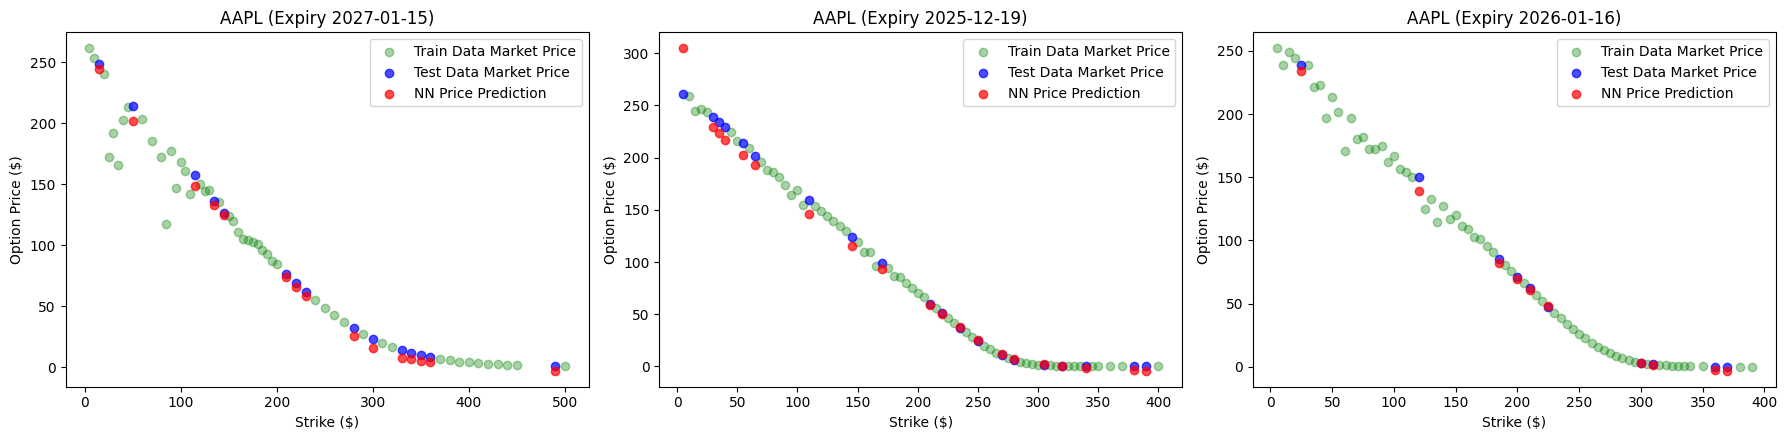

Statistical Analysis:

RMSE: 8.28516882
MAE: 5.04540351
R2: 0.98532444

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


Neural Network Predictions for MSFT:



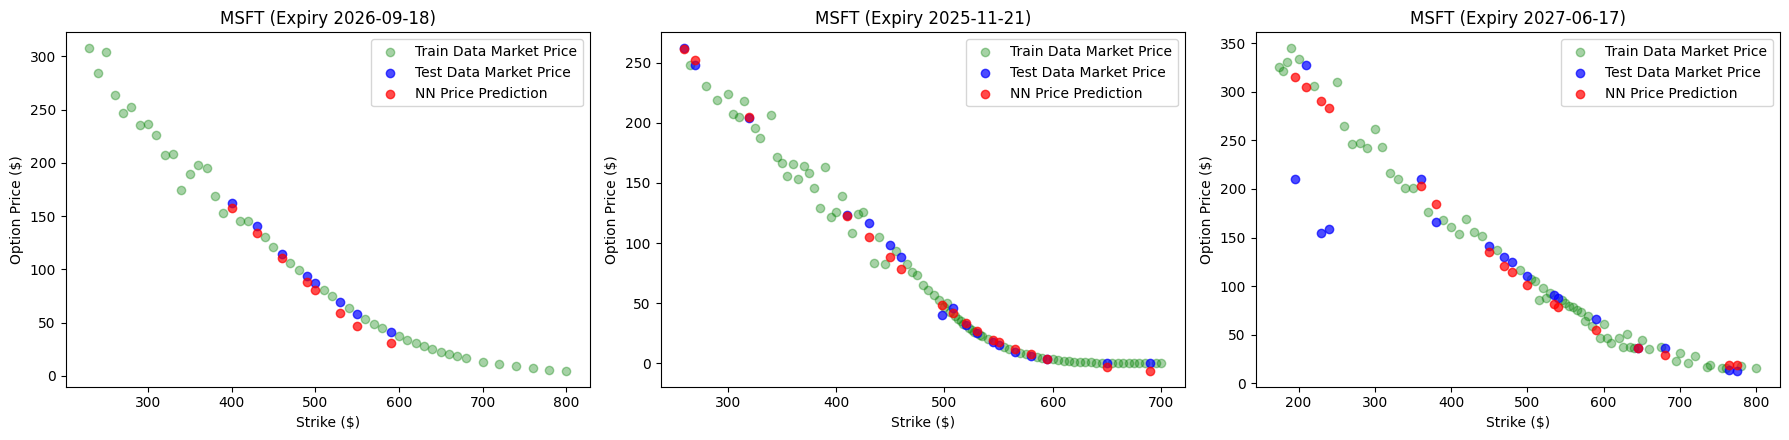

Statistical Analysis:

RMSE: 17.63257026
MAE: 8.55454748
R2: 0.96100299

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


Neural Network Predictions for AMZN:



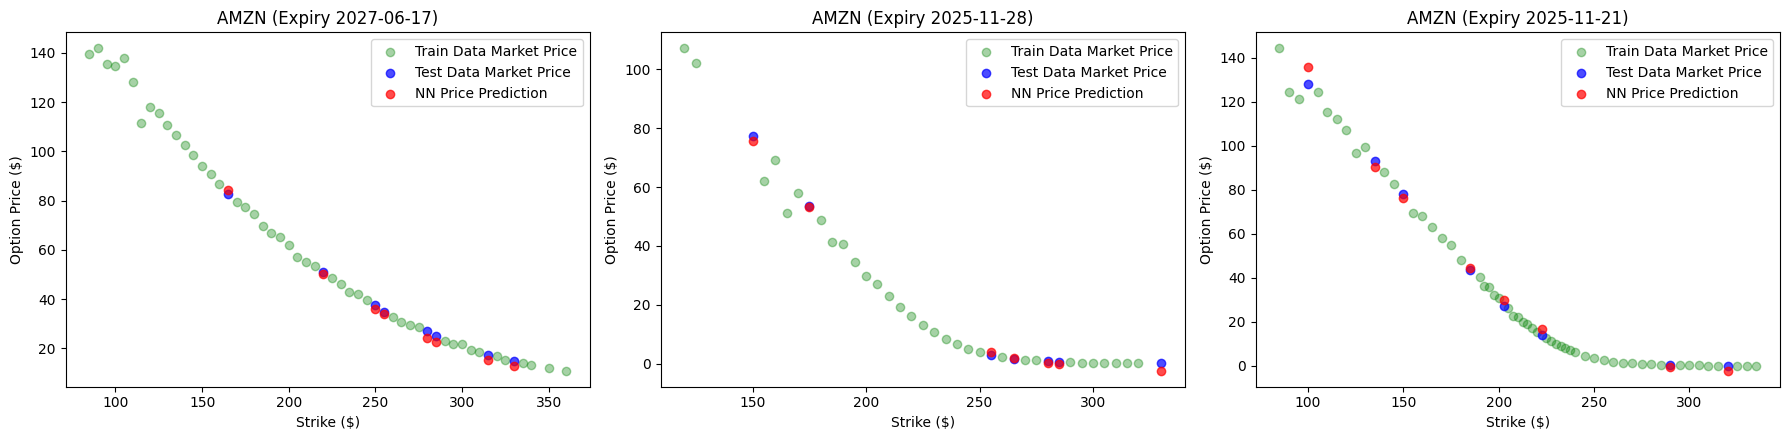

Statistical Analysis:

RMSE: 2.90755087
MAE: 2.24835546
R2: 0.99509060

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


Neural Network Predictions for GOOGL:



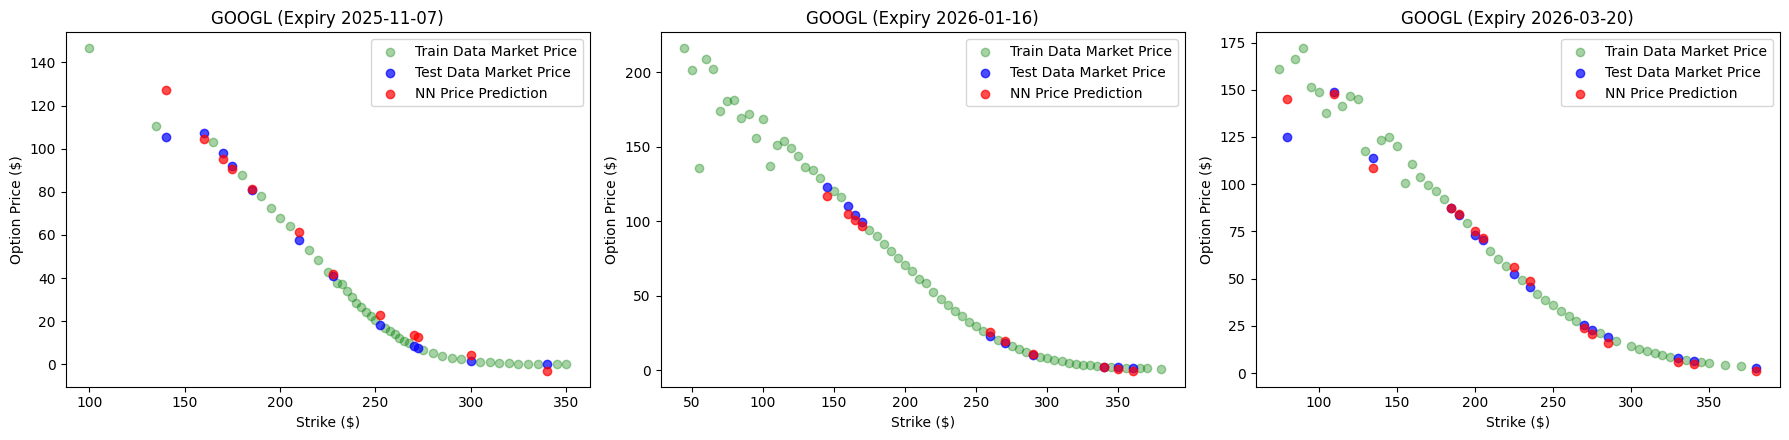

Statistical Analysis:

RMSE: 6.52547688
MAE: 4.47307290
R2: 0.98463473

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


Neural Network Predictions for META:



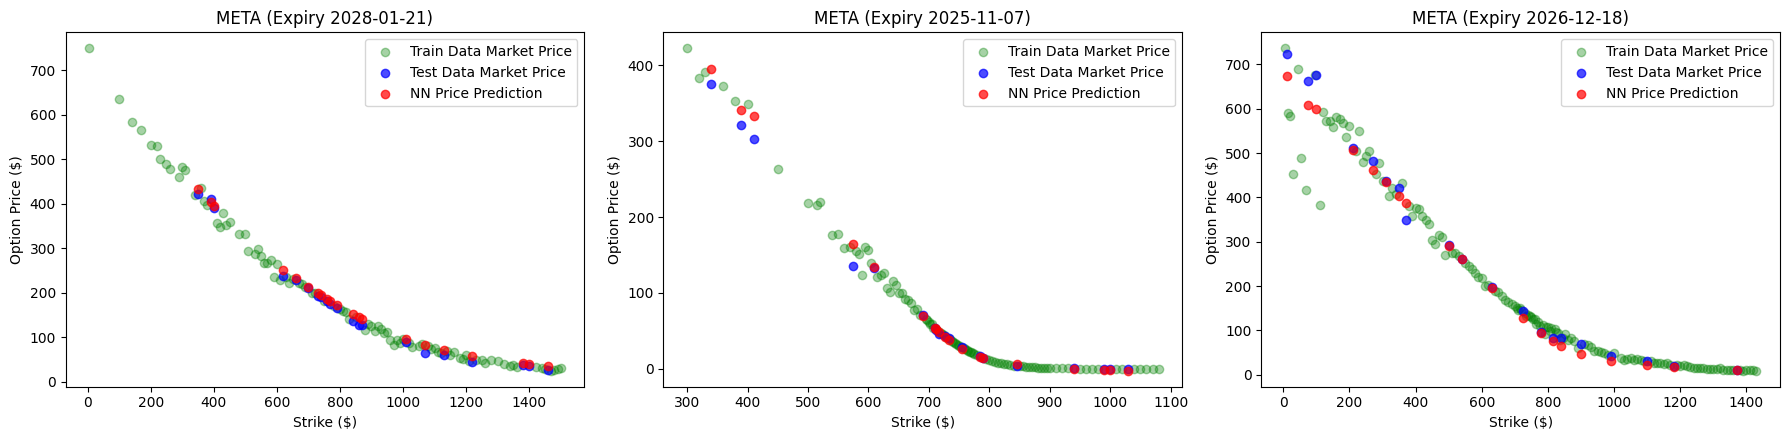

Statistical Analysis:

RMSE: 26.84156271
MAE: 13.32808841
R2: 0.98065642

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////



In [33]:
#Run the function and plot the comparisons to visialise the accuracy of the neural network for each company
for company in companies:

    print(f"\nNeural Network Predictions for {company}:\n")
    plot_nn_with_train(company, data_for_NN, predictions, n_expiries=num_expiries)

    #Print the statistical analysis for each company
    print("Statistical Analysis:\n")
    for i,j in nn_stats[company].items():
        print(f"{i}: {j:.8f}")
    print("\n////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////\n")

## XGBoost

The next Machine Learning model to implement is the XGBoost Regressor, used similarly to predict option prices for each company. XGB stands for Extreme Gradient Boosting, and is another supervised learning algorithm utilizing gradient descent. It builds a sequence of decision trees where each tree corrects and improves from errors made previously, leading to highly accurate predictions. 

The training and test data are reused from the Neural Network; the model is then trained on the training data, and used to make predictions on the test set. The results are stored in dictionaries, including the model's statistical performance using the previously defined model_stats() function. 

All parameters have been fine-tuned to prevent overfitting while simultaneously ensuring the model is not underfit.

In [53]:
from xgboost import XGBRegressor

#Dictionaries to store stats and predictions for each company
xgb_stats = {}
xgb_predictions = {}

#Define model parameters
n_estimators = 1750 #Number of trees, too high can cause overfitting
learning_rate_xgb = 0.03 #Step size controlling for each tree, regulates the weight of new trees to prevent overfitting
max_depth = 7 #Maximum depth of each tree
sub_sample = 0.9 #Fraction of samples used per tree, for regularization  
colsample_bytree = 1 #Fraction of features used per tree - set to 1 as there aren't too many input features for overfitting to be a concern

#Loop over each company to train a model for each one
for company in companies:

    #Retrieve data from the Neural Network
    xgb_X_train = data_for_NN[company]["X_train_scaled"]
    xgb_y_train = data_for_NN[company]["y_train"]
    xgb_X_test = data_for_NN[company]["X_test"]
    xgb_y_test = data_for_NN[company]["y_test"]

    #Create the model and fit to training data
    xgb_model = XGBRegressor(n_estimators = n_estimators, learning_rate = learning_rate_xgb, max_depth = max_depth, subsample = sub_sample)
    xgb_model.fit(xgb_X_train, xgb_y_train)

    #Generate predictions on the unseen test data and store in the dictionary
    xgb_y_pred = xgb_model.predict(xgb_X_test)

    xgb_predictions[company] = {
        "y_test_xgb": xgb_y_test,
        "y_pred_xgb": xgb_y_pred
    }

    #Compute the statistical analysis for each company
    xgb_stats[company] = model_stats(xgb_y_test, xgb_y_pred)

### Plotting XGBoost

Next step is to define the function to plot predicted values using XGBoost against real market values. The features are extracted, rescaled and combined into a DataFrame for plotting. A random sample of expiries are selected for plotting. Green points are the training set market values (shown to visualise the general trend), blue points are the test set market values, and the red points are the XGBoost model predictions for the test values.



In [54]:
def plot_xgb_with_train(company, data_for_NN, n_expiries=num_expiries):
    
    #Recover test data
    X_test = data_for_NN[company]["X_test"]
    y_test = xgb_predictions[company]["y_test_xgb"]
    y_pred = xgb_predictions[company]["y_pred_xgb"]
    test_expiries = data_for_NN[company]["expiry_test"]

    #Recover training data
    X_train = data_for_NN[company]["X_train_scaled"]
    y_train = data_for_NN[company]["y_train"]
    expiries_train = data_for_NN[company]["expiry_train"] 

    #Obtain feature names for DataFrame columns
    feature_names = data_for_NN[company]["features"]

    #Rescale data for plotting
    scaler = data_for_NN[company]["scaler"]
    X_train = scaler.inverse_transform(X_train)
    X_test = scaler.inverse_transform(X_test)
    
    #Create DataFrames for plotting with all useful information, including expiry dates
    df_test = pd.DataFrame(X_test, columns=feature_names)
    df_test["MarketPrice"] = y_test
    df_test["XGB_Prediction"] = y_pred
    df_test["ExpiryDate"] = test_expiries
    df_test["Dataset"] = "Test"

    df_train = pd.DataFrame(X_train, columns=feature_names)
    df_train["MarketPrice"] = y_train
    df_train["ExpiryDate"] = expiries_train
    df_train["Dataset"] = "Train" #Tag the type of dataset

    #Combine DataFrames into one
    df_plot = pd.concat([df_train, df_test], ignore_index=True)

    #Take a random sample of unique expiry dates
    unique_expiries = df_plot["ExpiryDate"].unique()
    sample_expiries = random.sample(list(unique_expiries), n_expiries)

    #PLot the subplots for each company
    plt.figure(figsize=(18, 4.5))
    for i, expiry in enumerate(sample_expiries):
        plt.subplot(1, n_expiries, i + 1)

        #Sort data by strike price to veiw the trend
        sorted_data = df_plot[df_plot["ExpiryDate"] == expiry].sort_values("Strike")

        #Plot the training data (green)
        train_plots = sorted_data[sorted_data["Dataset"] == "Train"]
        plt.scatter(train_plots["Strike"], train_plots["MarketPrice"], label="Train Market Price", color="green", alpha=0.35)

        #Plot the test data (blue) and corresponding predictions from the XGBoost model (red)
        test_plots = sorted_data[sorted_data["Dataset"] == "Test"]
        plt.scatter(test_plots["Strike"], test_plots["MarketPrice"], label = "Market Price", color = "blue", alpha=0.7)
        plt.scatter(test_plots["Strike"], test_plots["XGB_Prediction"], label="XGBoost Prediction", color="red", alpha=0.7)

        plt.xlabel("Strike ($)")
        plt.ylabel("Option Price ($)")
        plt.title(f"{company} (Expiry {expiry.date()})") #Raw expiry date used in title
        plt.legend()

    plt.tight_layout()
    plt.show()


XGBoost Predictions for AAPL:



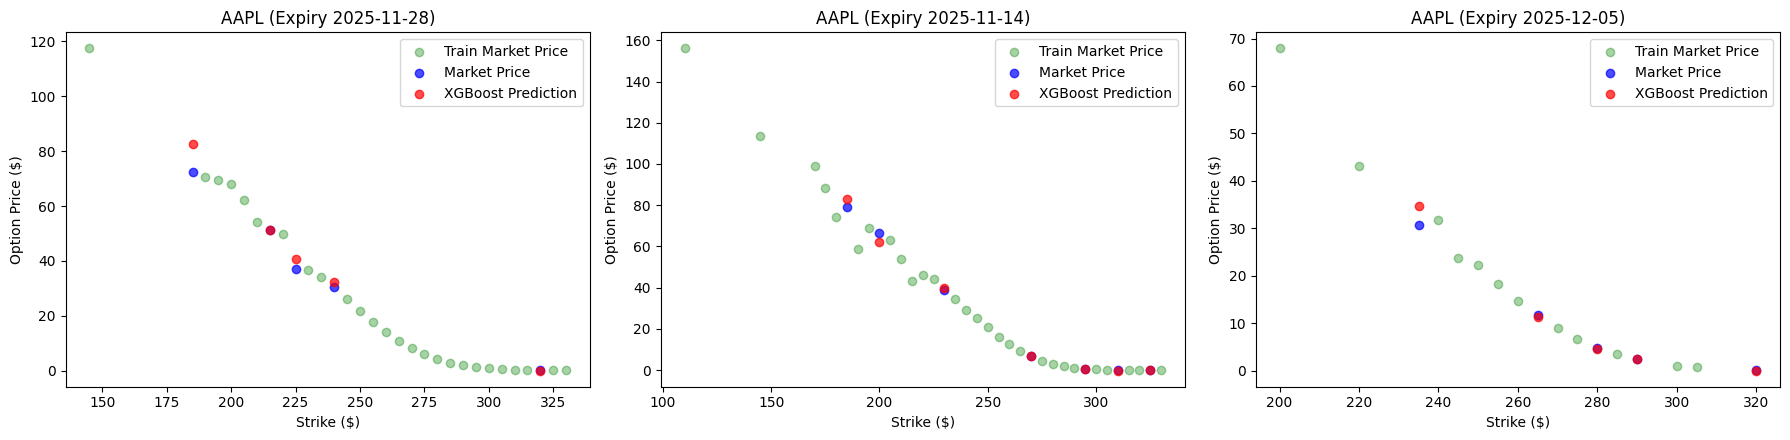


Statistical Analysis for AAPL (XGBoost):
RMSE: 5.85869924
MAE: 3.19881430
R2: 0.99266172

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


XGBoost Predictions for MSFT:



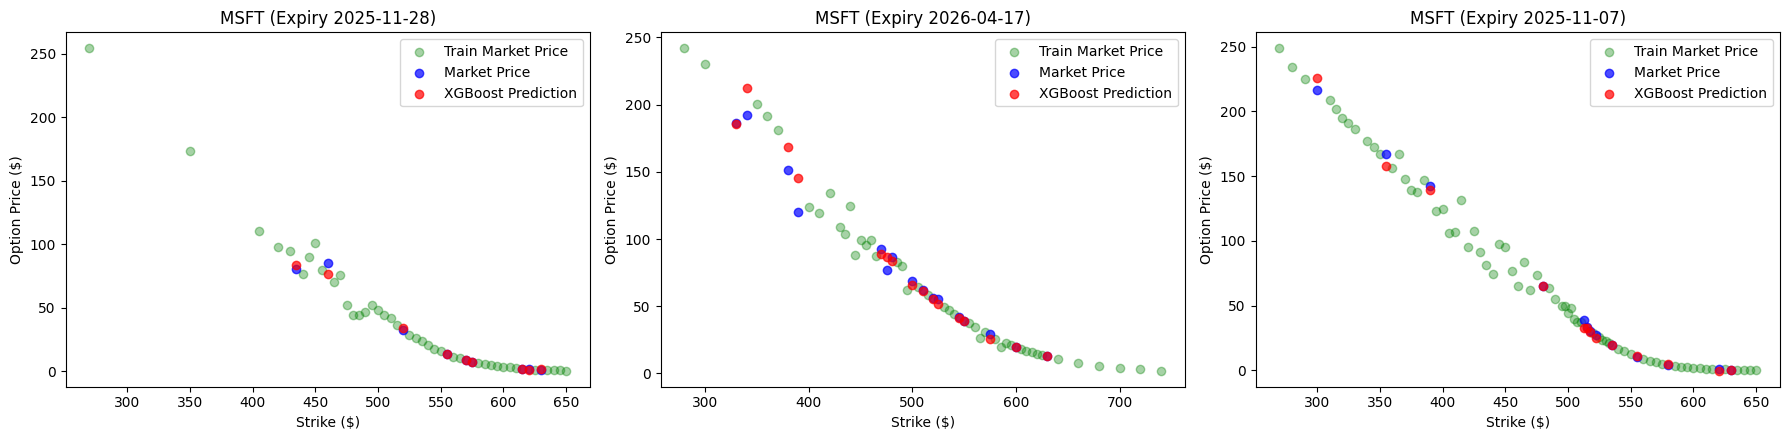


Statistical Analysis for MSFT (XGBoost):
RMSE: 18.18964538
MAE: 7.68310557
R2: 0.95849996

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


XGBoost Predictions for AMZN:



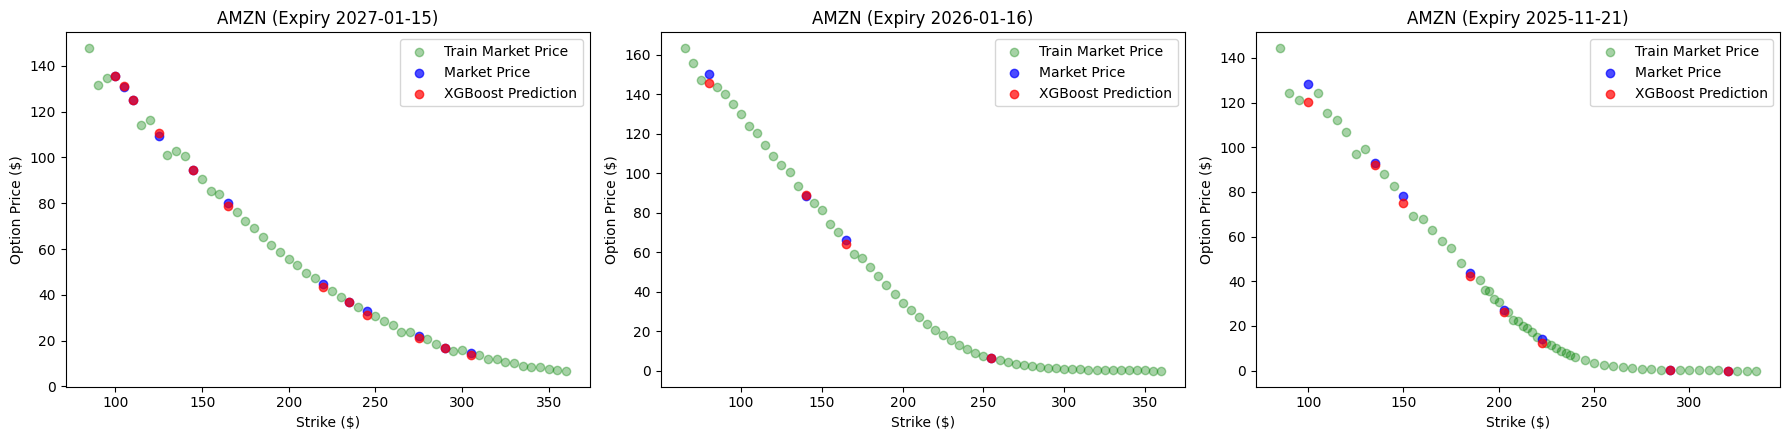


Statistical Analysis for AMZN (XGBoost):
RMSE: 2.31148680
MAE: 1.27057519
R2: 0.99689718

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


XGBoost Predictions for GOOGL:



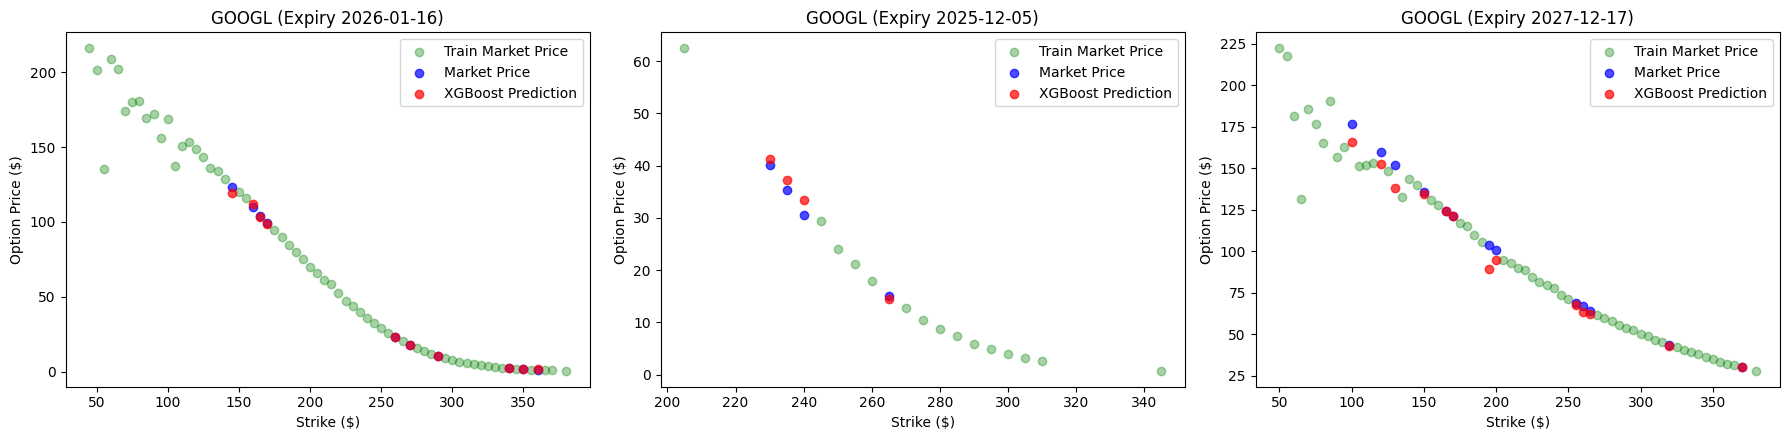


Statistical Analysis for GOOGL (XGBoost):
RMSE: 7.72016791
MAE: 3.87677930
R2: 0.97849353

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


XGBoost Predictions for META:



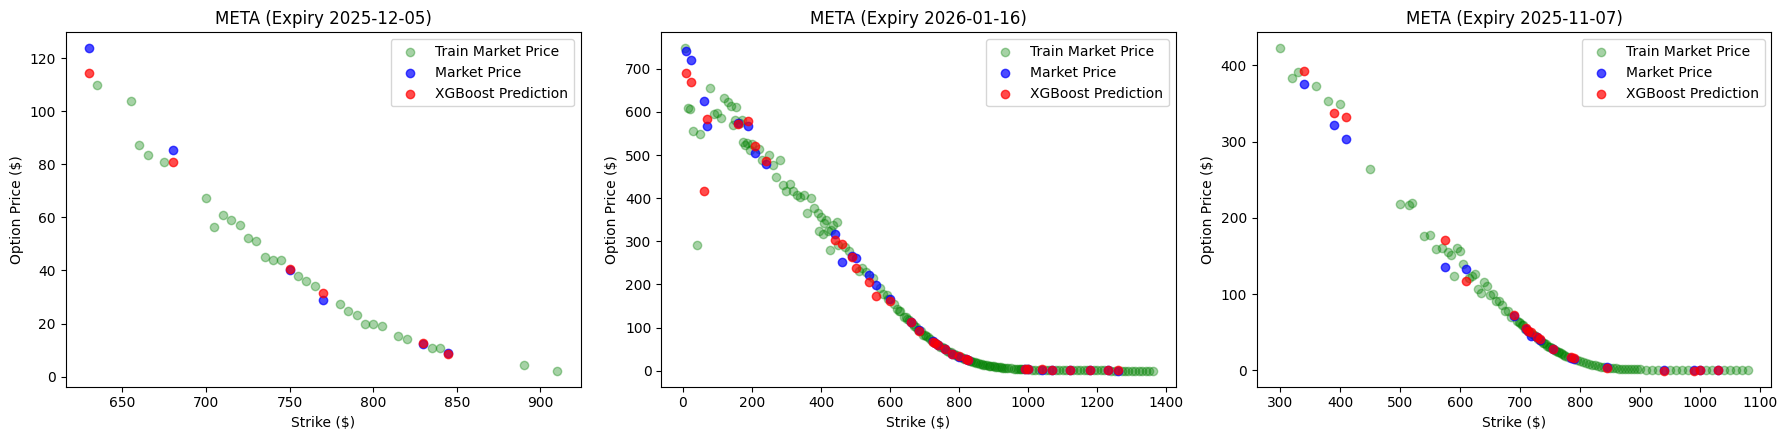


Statistical Analysis for META (XGBoost):
RMSE: 27.27381172
MAE: 10.23014700
R2: 0.98002840

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////



In [55]:
#Run the function to visualise trend and accuracy of the XGBoost model for each company
for company in companies:
    print(f"\nXGBoost Predictions for {company}:\n")
    plot_xgb_with_train(company, data_for_NN, n_expiries=num_expiries)

    #Print the statistical analysis for each company
    print(f"\nStatistical Analysis for {company} (XGBoost):")
    for i, j in xgb_stats[company].items():
        print(f"{i}: {j:.8f}")
    print("\n///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////\n")


## Results and Statistical Analysis

In this section, the three models - Black-Scholes, Neural Network and XGBoost will be compared via statistical analysis. 

The models were evaluated using the three metrics computed previously. Root Mean Squared Error (RMSE) measures the root of the average squared error between model prediction and real prices, therefore the lower the RMSE the higher the predictive accuracy of the model. Mean Absolute Error (MAE) measures the average absolute difference between the predictions and real prices, where a lower value also indicated better accuracy. The difference is MAE is less sensitive to outliers, whilst RMSE emphasises larger errors. Finally, the R-Squared score indicates how well the model's predictions matches the real data - values closer to 1 indicating a better fit.

The first step is to combine all the data into a DataFrame, which will help to plot results. 

In [37]:
#Initialize a list to store statistics for each company
combined_stats = []

#Loop over all companies, appending the model name, company, and statistical metrics previously stored in dictionaries
for company in companies:

    #Append Black-Scholes data
    combined_stats.append(["Black-Scholes", company, all_bs_stats[company]["RMSE"], all_bs_stats[company]["MAE"], all_bs_stats[company]["R2"]])

    #Append Neural Network data
    combined_stats.append(["Neural Network", company, nn_stats[company]["RMSE"], nn_stats[company]["MAE"], nn_stats[company]["R2"]])

    #Append XGBoost data
    combined_stats.append(["XGBoost", company, xgb_stats[company]["RMSE"], xgb_stats[company]["MAE"], xgb_stats[company]["R2"]])

#Combine all stats into a DataFrame
all_stats = pd.DataFrame(combined_stats, columns=["Model", "Company", "RMSE", "MAE", "R2"])
print(all_stats)

             Model Company       RMSE        MAE        R2
0    Black-Scholes    AAPL  15.372029   8.983166  0.947120
1   Neural Network    AAPL   8.285169   5.045404  0.985324
2          XGBoost    AAPL   5.858699   3.198814  0.992662
3    Black-Scholes    MSFT  26.041237  17.025285  0.925545
4   Neural Network    MSFT  17.632570   8.554547  0.961003
5          XGBoost    MSFT  18.189645   7.683106  0.958500
6    Black-Scholes    AMZN   5.730443   4.157602  0.982151
7   Neural Network    AMZN   2.907551   2.248355  0.995091
8          XGBoost    AMZN   2.311487   1.270575  0.996897
9    Black-Scholes   GOOGL  16.414135   8.988372  0.911846
10  Neural Network   GOOGL   6.525477   4.473073  0.984635
11         XGBoost   GOOGL   7.720168   3.876779  0.978494
12   Black-Scholes    META  36.138628  19.176562  0.963261
13  Neural Network    META  26.841563  13.328088  0.980656
14         XGBoost    META  27.273812  10.230147  0.980028


Here we define a function, taking the statistical metric we want to compare as an argument, as well as all the company data, to plot the comparison of each metric across the models. Each plot has the companies on the x-axis, and the error metric on the y-axis. Scatter plots with connecting lines were used to clearly illustrate model performance per company. This method makes it easy to identify which models perform better/worse.

In [38]:
def model_comparison(all_stats, companies, metric):

    #Create a dictionary of models and corresponding colours
    plt.figure(figsize=(12,5))
    colours = {
        "Black-Scholes": "#E9C46A",
        "Neural Network": "#284957",
        "XGBoost": "#2A9D8F"
    }

    #Retrieve data for each model and plot
    for model, colour in colours.items():
        current_model = all_stats[all_stats["Model"] == model]
        plt.plot(companies, current_model[metric], marker='o', linestyle="-", label=model, color=colour)

    plt.title(f"Comparison of {metric} across all models")
    plt.xlabel("Company")
    
    #Ensure y-axis units are correct (R2 Score is unitless)
    if metric == "R2":
        plt.ylabel(f"{metric} Score")
    else:
        plt.ylabel(f"{metric} ($)")
        
    plt.legend()
    plt.tight_layout()
    plt.show()



Starting with the Root Mean Squared Error, individually run the function for analysis of the models with each metric.

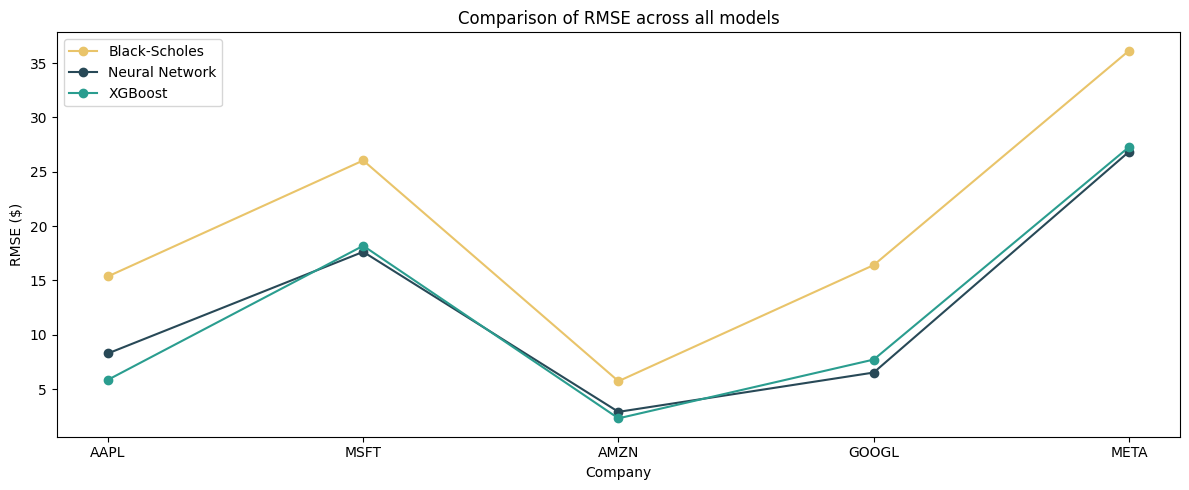

In [39]:
RMSE_comparison = model_comparison(all_stats, companies, "RMSE")

As discussed, a lower RMSE indicates higher model accuracy. From the plot, the Black-Scholes model consistently has the highest RMSE, suggesting the model doesn't capture the market as effectively as the ML models. However, for AMZN the RMSE is very close to the other models, and therefore may be preferred for this company due to its easy implementation.

The Neural Network and XGBoost models achieve very similar RMSE values for each company. Both models follow the same overall trend; AMZN having the lowest RMSE and META having the highest. However, the Neural Network slightly outperforms the XGBoost model in 3/5 cases, and produces the lowest RMSE values overall. However, the XGBoost performs a little better for AMZN and APPL, with the lowest RMSE. It is important to note, that these values change daily, before XGBoost has been seen outperforming on 4/5 cases. There is an element of randomness and luck involved.

Overall, the results show better RMSE values for the ML approaches, with XGBoost exhibiting the best results overall.

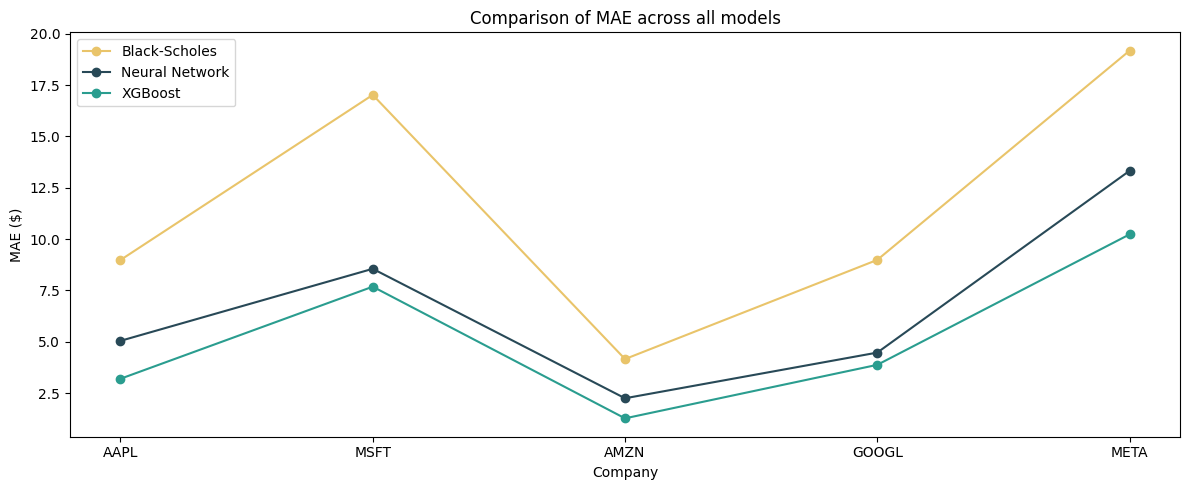

In [40]:
MAE_comparison= model_comparison(all_stats, companies, "MAE")

The MAE results closely reflect the RMSE comparison. Just like before, the Black-Scholes model exhibits the highest MAE values, again suggesting lower predictive accuracy compared to the machine learning approaches. 

Both the Neural Network and XGBoost models demonstrate lower MAE for all companies, and the trends also remain consistent. However, XGBoost slightly outperforms the neural network for all 5/5 companies. 

Intrestingly, for GOOGL, the neural network achieved a lower RMSE but slightly higher MAE compared to XGBoost. This is because RMSE treats larger errors more significantly, due to squaring the errors, whilst MAE treats all errors equally. This suggests that the Neural Network may have produced a few outliers, whilst maintaining overall closer fits. XGBoost may have had less outliers, but slightly less well fit overall due to the higher RMSE. However it is important to note that the differences between MAE and RMSE are marginal, both models perform strongly compared with the Black-Scholes.

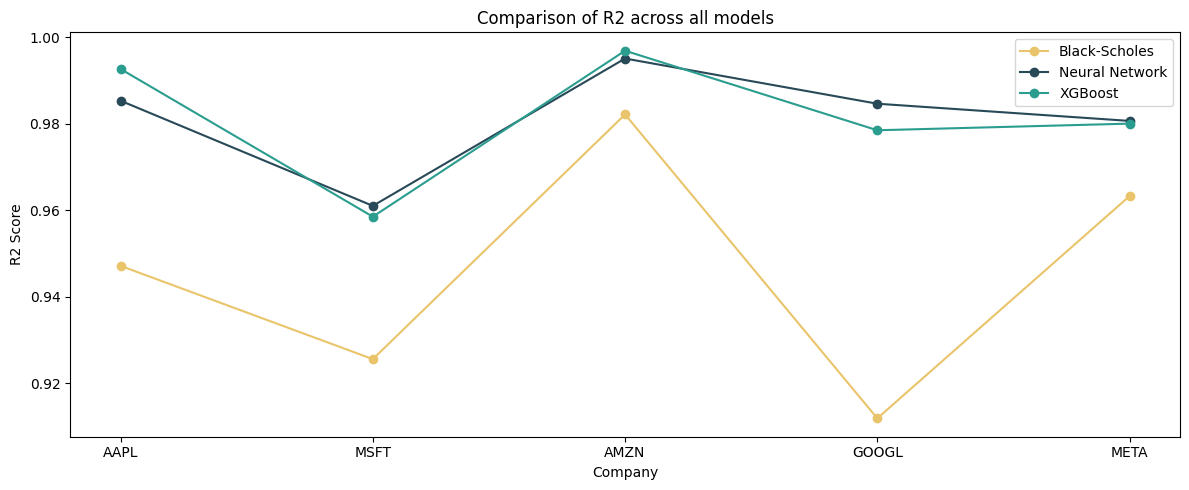

In [41]:
R2_comparison = model_comparison(all_stats, companies, "R2")

The R-Squared results reflect the RMSE very closely - the lower the RMSE, the higher the R2 value. The Black-Scholes model consistently exhibits the lowest values, ranging from approximately 0.94 - 0.99(for AMZN). For AMZN the BS performance is very similar to the ML models, consistent with the earlier conclusion that AMZN has less error overall.

For the two ML models, XGBoost slightly outperforms once agian on (3/5) companies, achieving slightly higher R2 values. The exceptions are MSFT and APPL, where the neural network has the best R2 value. This suggests the XGBoost model fits the data slighyly better overall than the Neural Network.

It is important to note that differences in R2 values are marginal,also changing daily; both models are able to capture the data with very high R2 results. 

### Comparing Averages

In [42]:
avgs = []
models = all_stats["Model"].unique() #Retrieve model names

for model in models:

    #Retrieve stats for each model
    model_data = all_stats[all_stats["Model"] == model]

    #Calculate the averages of each metric for that model
    mean_rmse = model_data["RMSE"].mean()
    mean_mae = model_data["MAE"].mean()
    mean_r2 = model_data["R2"].mean()

    avgs.append([model, mean_rmse, mean_mae, mean_r2])

mean_stats = pd.DataFrame(avgs, columns=["Model", "RMSE", "MAE", "R2"])
    
print("Statistical metric average for each model:")
print(mean_stats)

Statistical metric average for each model:
            Model       RMSE        MAE        R2
0   Black-Scholes  19.939294  11.666197  0.945985
1  Neural Network  12.438466   6.729894  0.981342
2         XGBoost  12.270762   5.251884  0.981316


## Discussion and Conclusion

Fascinatingly, both the Neural Network and the XGBoost achieve the same R2 score of 0.9813. This is a 3.66% difference with the Black-Scholes model. Since R2 values tend to be above 90% for models, an increase of 3.66% is a noticeable difference, highlighting the accuracy of machine learning methods without taking away from the BS model. 

Both NN and XGBoost exhibited similar Root Mean Squared Error and Mean Average Error values, with XGBoost outperforming slightly. Both machine learning methods had an approximate 38.1% improvement in RMSE compared to the Black-Scholes model. The Neural Network and XGBoost model also displayed a 42.31% an 55.00% improvement in MAE results.

Throughout this project, two machine learning systems have been assembled and trained to predict real option prices. Both models, the Neural Network and the XGBoost model outperform the traditional Black-Scholes model based on all statistical metrics, and clear vizualisation from the plots. Despite the Black-Scholes being one of the most important equations in finance, the reason it fails in comparison to the ML models are most likely due to the assumptions the model takes. Assuming constant volatility and frictionless markets (perfectly efficient transactions) affect predictions when in reality this is rarely the case. The machine learning models are trained on real data, therefore negating these assumptions and able to fit better with the data. 

Between the two machine learning models, XGBoost performed slightly better when taking into account average metric scores - slightly lower RMSE and MAE scores. However, the Neural Network was not far behind, even outperforming XGBoost in some cases, and achieving the same R2 score. In conclusion, both of the models fit very well to the data. The small differences in results could be due to differences in how each model was built, with slight changes in parameters causing different results. 

There are some limitations for both models, despite the accurate results. For example, the models have not undergone extensive parameter tuning, potentially resulting in slightly weaker models being built. There are also some limitations within the dataset - short-term expiries seem to exhibit more random/unpredictable behaviour, and sometimes yfinance has errors with the implied volatility data, leading to errors in the models (particularly Black-Scholes, leading to unfair comparison against the models). 

There are several improvements that could work towards settling these limitations, and make the models and comparisons more accurate overall. Collecting more data is the best way to prevent overfitting of a  ML model, and also make the model more accurate. Also, adding more input features could improve the accuracy of the model - currently the only input features used are those present in the Black-Scholes model. Regularisation could also be explored, important for preventing overfitting where necessary. Furthermore, it may be beneficial to use snapshots of data instead of live data; if there is a problem with data from yfinance (e.g. with implied volatility being seen as 0 before) then the models can become less accurate. Furthermore, in the interest of runtime, multiple NN and XGB models were not shown to be trained and tested to find the best one, however this would be an easy addition using loops, to make the models more robust.

Overall, both models show how real-world option data is better modelled using machine learning rather than the traditional Black-Scholes model, and how extremely well fit models can be created to match data as complex as option prices. 